Isak Schwartz: - hours Anton Forsberg: - hours

# Assignment 3

In [1]:
#imports
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
from sklearn.preprocessing import StandardScaler

# choose data
#path = 'data_200.csv'
#path = 'data_500.csv'
path = 'data_all.csv'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1: scatter plot

      residue name  position chain         phi         psi
0              LYS        10     A -149.312855  142.657714
1              PRO        11     A  -44.283210  136.002076
2              LYS        12     A -119.972621 -168.705263
3              LEU        13     A -135.317212  137.143523
4              LEU        14     A -104.851467   95.928520
...            ...       ...   ...         ...         ...
29364          GLY       374     B -147.749557  155.223562
29365          GLN       375     B -117.428541  133.019506
29366          ILE       376     B -113.586448  112.091970
29367          ASN       377     B -100.668779  -12.102821
29368          LYS       378     B -169.951240   94.233680

[29369 rows x 5 columns]


Text(0, 0.5, 'psi (degrees)')

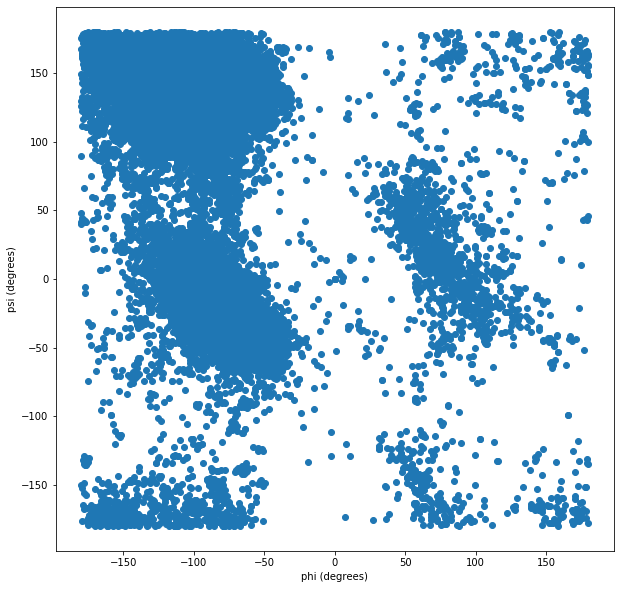

In [2]:
# read data
df = pd.read_csv(path)

# print data
print(df)

# scatter plot data
x = df['phi']
y= df['psi']
X = df[['phi','psi']]
plt.figure(figsize=(10,10))
plt.scatter(x, y)
# add labels
plt.xlabel('phi (degrees)')
plt.ylabel('psi (degrees)')
#plt.show()

## 2: K means clustering

### 2.a: Try different k values

In [3]:
def drawClusters(k): # k = # clusters
    # create clusters
    kmeans = KMeans(n_clusters=k, random_state=7).fit(X)
    
    plt.figure(figsize=(10,10))
    
    # we predict because we want to color the data points acording to what cluster they belong to
    predict = kmeans.predict(X)
    
    # draw data points
    plt.scatter(x, y, c=predict)

    # draw cluster centers
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')

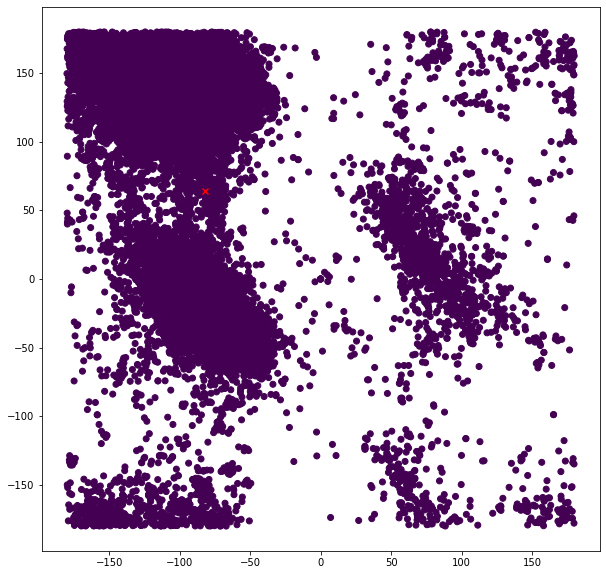

In [4]:
# k = 1
drawClusters(1)

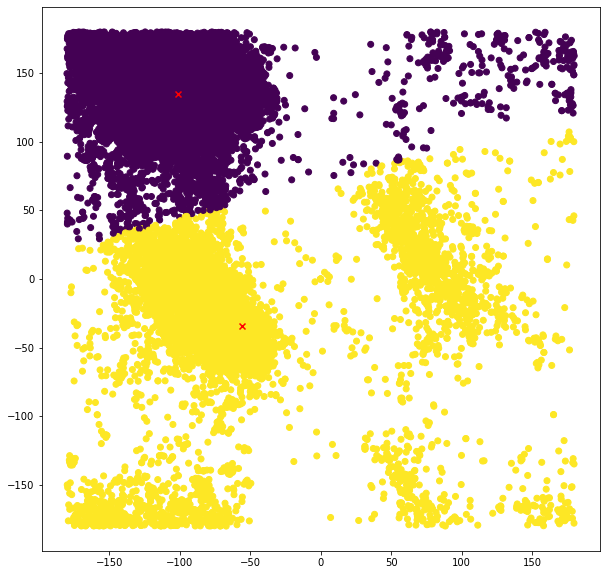

In [5]:
# k = 2
drawClusters(2)

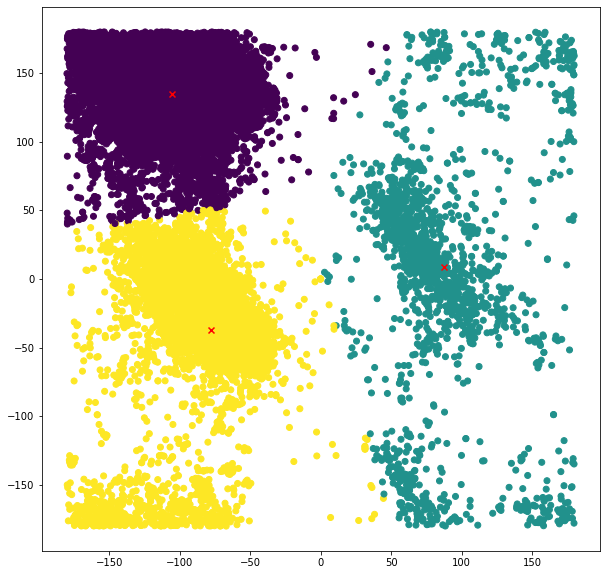

In [6]:
# k = 3
drawClusters(3)

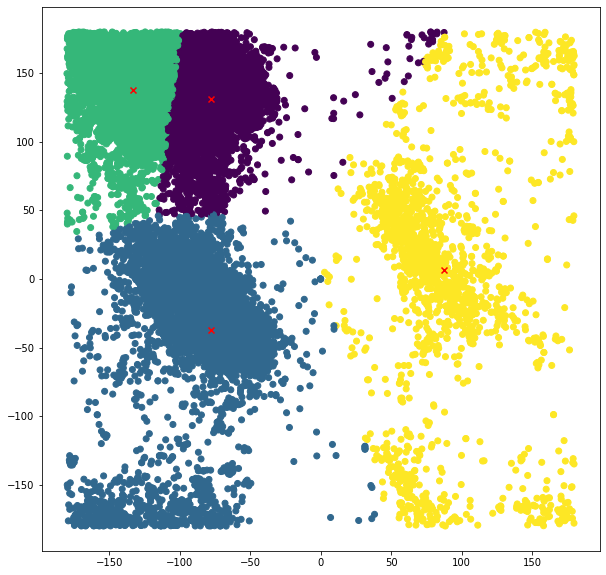

In [7]:
# k = 4
drawClusters(4)

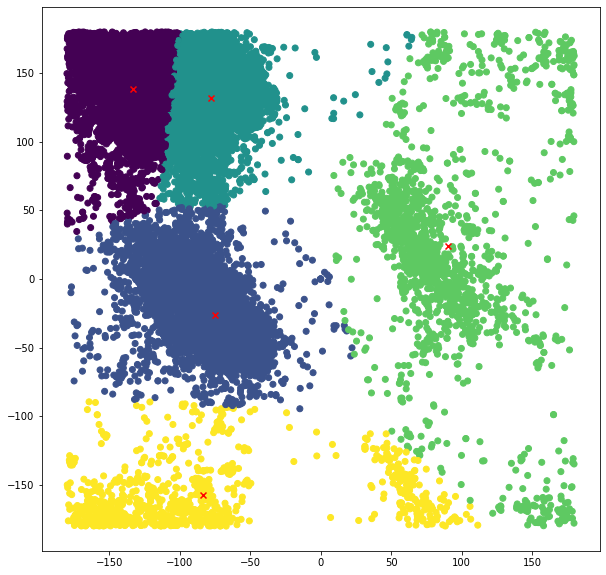

In [8]:
# k = 5
drawClusters(5)

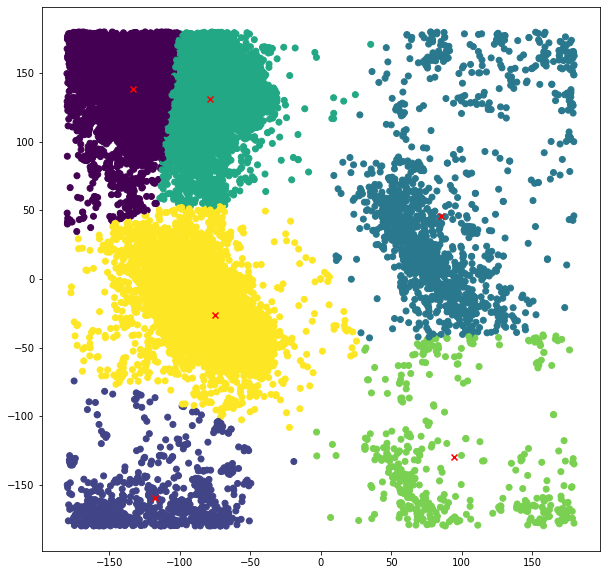

In [9]:
#k = 6
drawClusters(6)

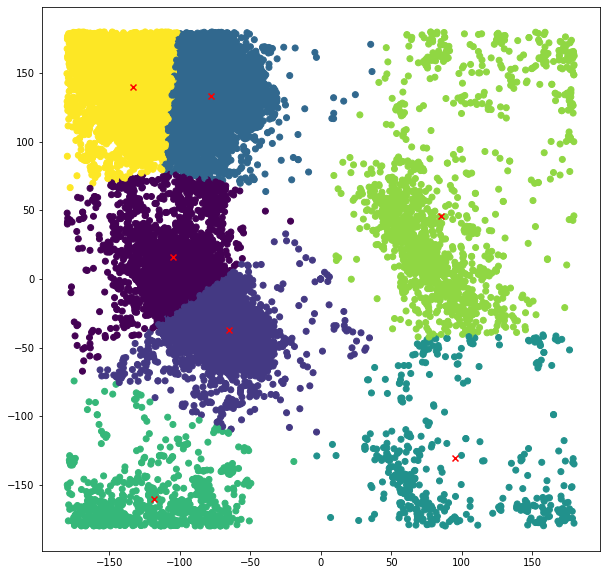

In [10]:
#k = 7
drawClusters(7)

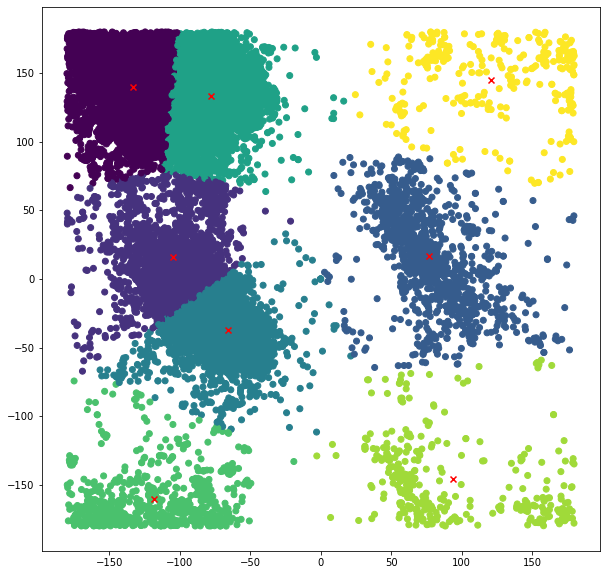

In [11]:
#k = 8
drawClusters(8)

We can assume there are 4 underlying clusters by looking at the scatter plot of the data, meaning k=4 is suitable. The clusters appear to be spread about some center point somewhat uniformly, meaning k-means clustering would be suitable here. DBSCAN could probably also work since the clusters aren't very close to each other. No two different clusters are centered around the same point in any part (wither locally or overall) though, meaning DBSCAN is not needed to separate the clusters.

By looking at the scatter plot we can assume there might be 4 to 5 underlying clusters, which becomes more apparent by shifting the data as shown in 2.d. There are 4 very distinguished clusters but one could also choose to see the bigger chunk between the two biggest clusters on the right as it's own cluster.

However if we solely look at the data in its direct form there seems to be 7 to 8 clusters. We get more clusters since two clusters are cut off at the top, wrapping around

In any case, this essentially means we get more clusters from the k-means clustering than what there are in practice. This is not a huge problem though since it is more important to divide clusters that belong to different underlying clusters than what it is to group all parts of each underlying clustes to the same cluster. This is because even if an underlying cluster gets divided up into 2 or more differe    nt cluster using k-means, we can still say that all those clusters should be categorized under the same category (the same underlying cluster).

### 2.b: Validate clusters

We use the elbow method to verify the clusters. The elbow method entails making a graph for k-means clusterings for different k values. The x axis has the k value and the y axis has the maximum distance betweem two points within the clusters. To find the best candidate according to this method, one should pick the k value corresponding to the point where the graph's slope changes the most. This is because this point generally corresponds to where increasing the k value will only mean dividing up already coherent clusters further, rather than dividing up clusters that actually consist of multiple clusters. The quick change of 

In [12]:
# X = # <your_data>
def ElbowCurve():
    distorsions = []
    for k in range(2, 15):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(2, 15), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')

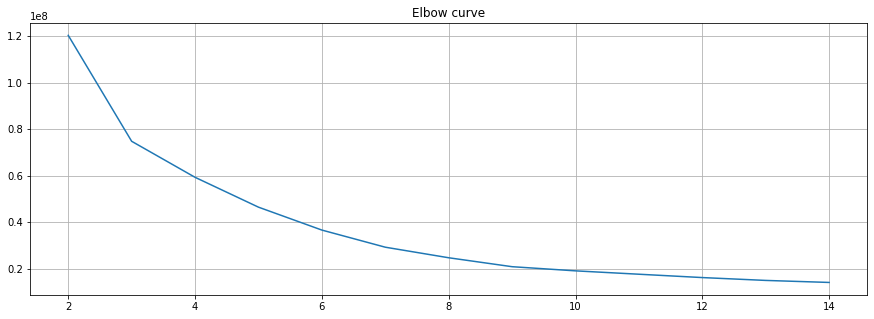

In [13]:
ElbowCurve()

### 2.c: Reason about clusters in 2.a
To expand on the the reasoning in 2.a, the centers for the cluster found using k-means with k=4 do all seem to be in the center for each cluster.

### 2.d: Shifting data for better results

In [14]:
def add360(n): 
    if n < 0:
        return n +360
    return n

In [15]:
df['phi'] = df['phi'].map( lambda n: add360(n))  # 2.d: Shifting data for better results
df['psi'] = df['psi'].map( lambda n: add360(n + 100)) # # 2.d: Shifting data for better results

x = df['phi']
y= df['psi']
X = df[['phi','psi']]

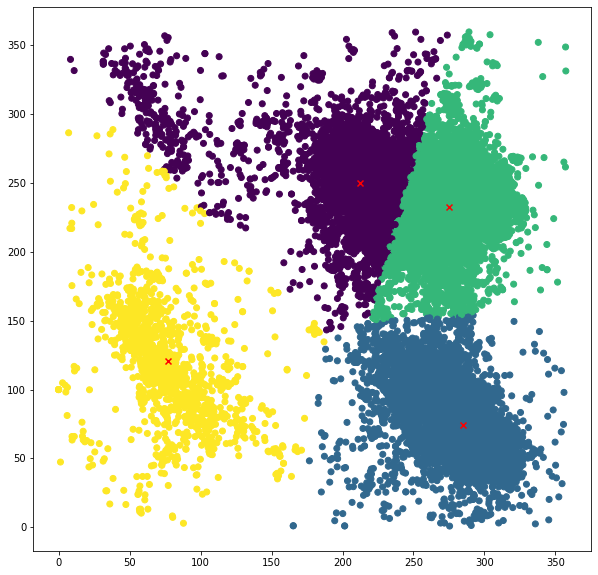

In [16]:
#k = 4
drawClusters(4)

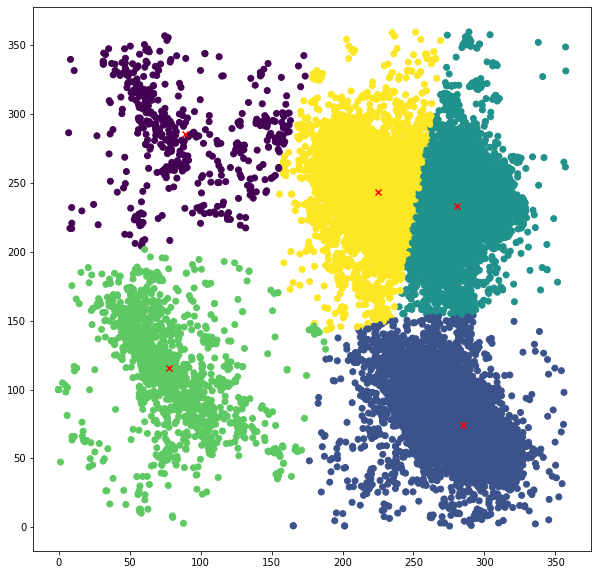

In [17]:
#k = 5
drawClusters(5)

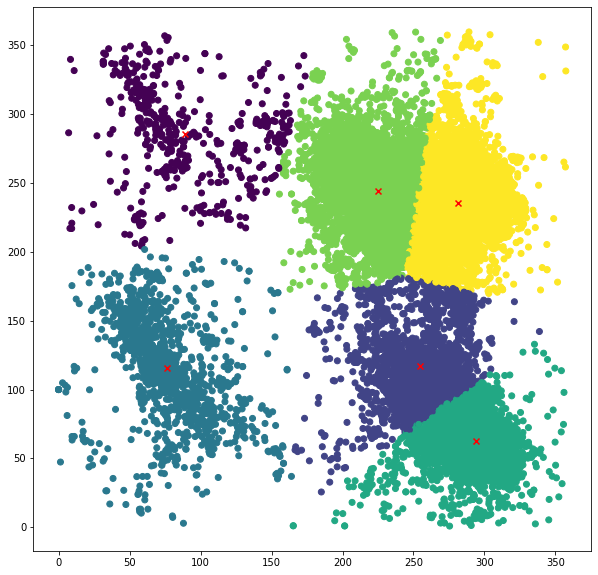

In [18]:
#k = 6
drawClusters(6)

#### Validate clusters with shifted data

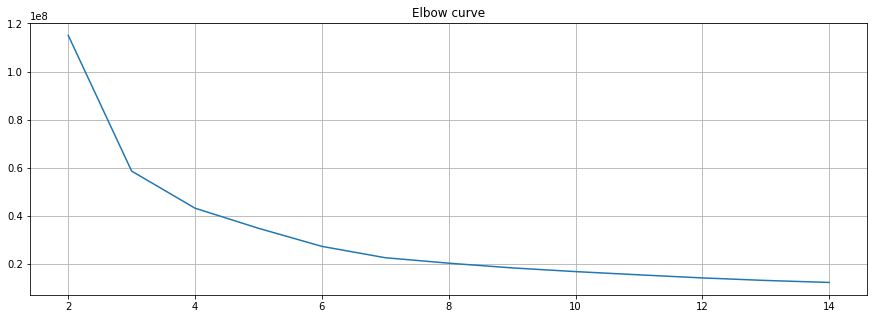

In [19]:
ElbowCurve()

## 3: DBSCAN clustering

In [20]:
# start point for centers
centers = [[1, 1], [-1, -1], [1, -1]]

X = StandardScaler().fit_transform(X)


In [21]:
# help function for creating bar charts of the most frequent outliers
def barplotOutliers(db):

    aminos = list(df['residue name'].unique()) # array of all the amino acid residue types 
    aminoOutliers = np.zeros(len(aminos)) # array filled with zeros. will stor the number of outliers for every amino acid residue type

    result = zip(df['residue name'],db.labels_)
    for name, label in result:
        if(label == -1): # outliers have the label -1
            index = aminos.index(name) 
            aminoOutliers[index] = aminoOutliers[index] + 1
    
    plt.figure(figsize=(10,5)) # change the size of the figure
    plt.bar(aminos, aminoOutliers) # plot the bar chart

    # add labels
    plt.ylabel('Outliers')
    plt.title('Most frequent outliers')

    plt.show()

In [22]:
# help function for drawing dbscans for given max distance and min sample
def drawDBSCAN(max_distance, min_samples):
    # Compute DBSCAN
    db = DBSCAN(max_distance, min_samples).fit(X)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # Plot result
    plt.figure(figsize=(10,10))
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    barplotOutliers(db)# draw bar plot of most frequent outliers
    
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

### 3.a: Motivate min samples & max distance

#### Choice of parameters
We experimented with different values, varying one parameter at a time to try and find values that would give 4 clusters and few noise points. We want this because there seems to be 4 main clusters and the fewer noise points we have, the more data will be able to be classified or clustered by the DBSCAN. 

However, We found that it is impossible or at least very hard to get 4 clusters that cover the actual clusters that one can see in the data. We were almost able to get 4 clusters which is described in case 4 below. However, it might be more valuable to only divide the data into 3 cluster since that can be done with less noise points, as described in case 2 and 3 below. In case 2 we include the sparse cluster at the top left, but let the two big clusters on the right merge together, and vice versa for case 3.

For each case, we show that the first demonstrated parameters for the DBSCAN give a good solution by demonstrating that increasing or deacreasing either of the two parameters will have some downside. These downsides include either giving more noise points or chaning the overall clustering such as merging two clusters or adding new small clusters. Note that the solutions arent 100% optimal, one could probably fine tune the parameters even more to reduce noise using some advanced solver, but we show that the solutions are sufficient by demonstrating that altering the parameters with a relatively small step will still make the clusterings worse. 

### 3.b: Visualization and outliers

#### case 1: 4 (really 5) clusters
It is possible to divide up the data into 4 main clusters according to how we want, using the values below, shown in the plot below. Note that we get one small extra cluster on the top right that should really belong to the big cluster below it, but we could just say that this small cluster actually belongs to the big one afterwards. Overall, this solution if not very good in practice, it does distinguish the 4 main clusters, but the main problem is that the top left cluster is very small. This means a lot of noise data points that that actually belong to the cluster in reality don't get included in the cluster. The same goes for the other cluster, we see a lot of noise points around them that we can easily where they actually belong. 

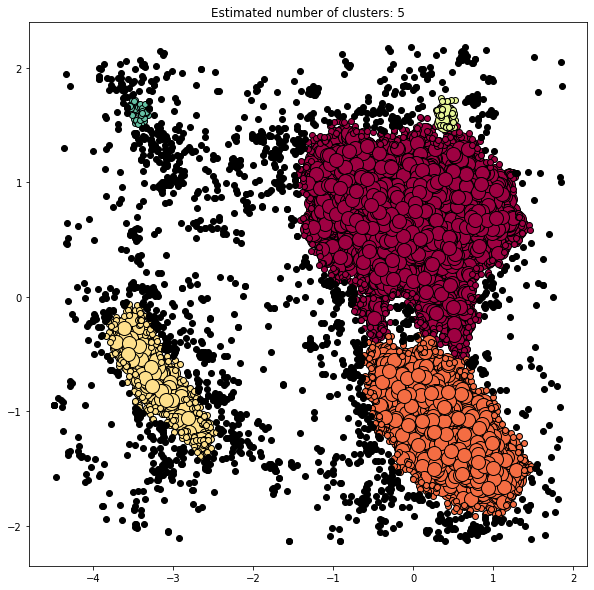

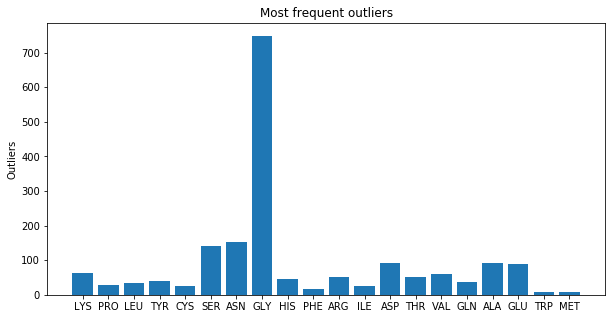

Estimated number of clusters: 5
Estimated number of noise points: 1810


In [23]:
drawDBSCAN(0.13,46)

#### case 2: 3 cluster (including top left data)
If we want to keep the sparse cluster on the top left and allow the two on the right to merge, the following values (0.5,120) seem to give a low amount of noise.

It was also easier to get less noise in this case than case 1, which means we can assign more data points to clusters.

The following 4 plots show that altering the values up and down won't reduce the amount of noise. Altering the values either gave more noise or gave 2 clusters rather than 3. It is possible and likely that one could reduce the amount of noise by fine tuning the values with more precision but it doesn't seem to improve drastically. Also, reducing noise too much could be bad since it would mean clustering some points that might be ambiguous; one point that seems to be right in between 2 clusters could still get assigned to one of the cluster even though it is very unlcear if it actually belongs there. In short, it can be good to have noise where it's uncertain where the data belongs.

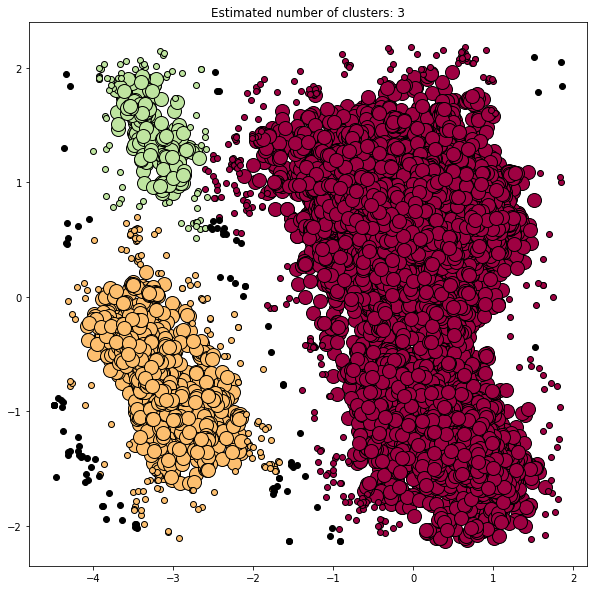

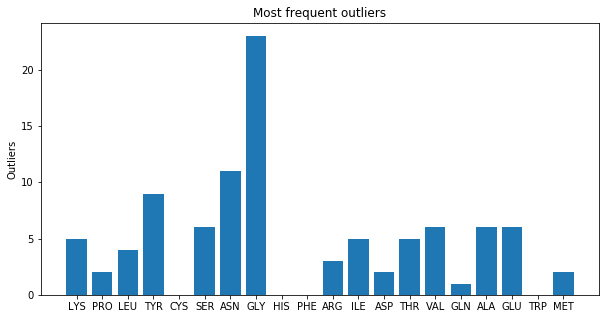

Estimated number of clusters: 3
Estimated number of noise points: 96


In [24]:
drawDBSCAN(0.5,120)

#### case 3: 3 clusters (excluding top left data)
In this case we omitt the clusters that could represent the data on the top left and letting it be noise. We do this by increasing each parameter compared to case 1 (0.157,68). Doing this clusters can only be created where there are more denser sections of data points, which omitts the sparse data points on the top left. We tuned the parameters like this to separate the two big clusters on the right, to do this we need to decrease the max distance and or the min samples so the section between the big to clusters dont connect. This section between the big two clusters is almost as dense as the sparse cluster on the top left, reason being why it gets omitted. Note that it is possible to include the sparse cluster on the top left as demonstrated in case 1, but if we decide to omitt it we can tune the parameters more freely to decrease the amount of noise, which is what we did in this case. 

We have more noise in this compared to case 2 since more sparse points around the big clusters are omitted, as explained above.

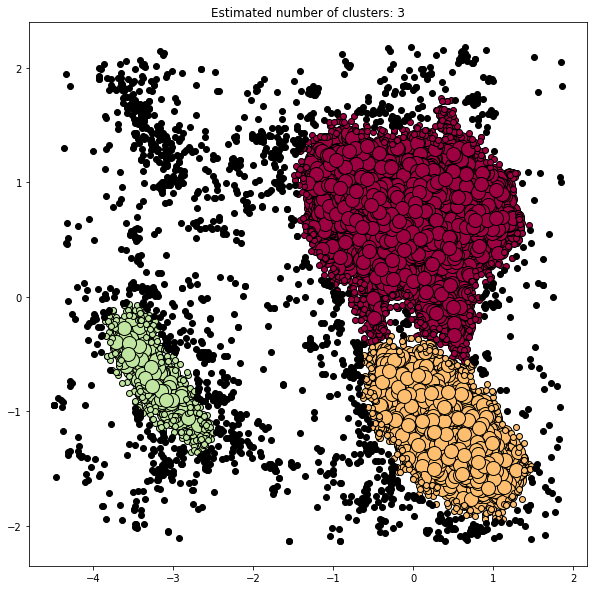

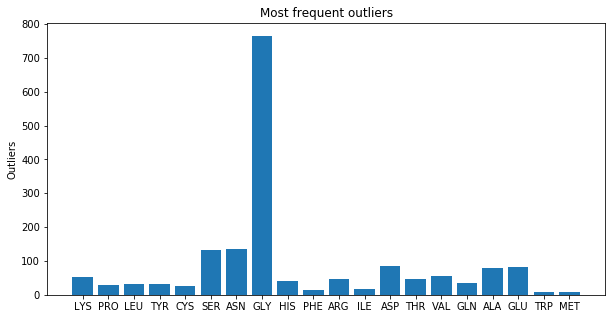

Estimated number of clusters: 3
Estimated number of noise points: 1722


In [25]:
drawDBSCAN(0.157,68)

#### Final candidate
It is hard to say which solution out of the 3 cases is the best without further context.

### 3.c: Compare DBSCAN and k means clusters

A strength of DBSCAN is that it can omitt points that are too close to 2 different clusters, meaning it's too hard to tell which cluster they should belong to. This can make the clusters have higher classify less datapoints incorrectly but it can also be a downside if you absolutely need all points to be classified, even at the cost of some inaccuracy. We also saw that having less noise often mean getting less clusters, merging together unerlying clusters, which is also bad.

One does seem to have more control for DBSCAN compared to k-means in this case. We can only use a few reasonable values for k in k-means but for DBSCAN there's an infinite combinations of parameters. Having more fine tuning available can be good for making clusters that need to be precise, but it is also slower to do for that reason. It is probably harder to make DBSCAN clusters automatically since you can't input the number of clusters you want into the algorithm, it still needs to be tuned by hand. As for k-means, simply entering the number of clusters as k value is often sufficient for getting the best clustering you can get with k-means (entering start points for centroid points will also help, but is relatively easy to do by eye). This means a k-means clustering can be done fast since you dont need to tune it as much, You might need to use the elbow method to choose the correct k value if the amount of underlying clusters is not obvious, but this can also be done automatically.

Overall, DBSCAN is better in this case since we have time to fine tune so we can make clusterings somewhat true to the underlying data while having some noise points to demonstrate data that we are too uncertain to classify, which can be good.

### 3.d: Robustness of DBSCAN

## 4: Comparison of clusters

In [26]:
def compareCluster(residueName):
    residue = df.loc[df['residue name'] == residueName]
    not_residue = df.loc[df['residue name'] != residueName] 
    
    plt.figure(figsize=(10,10))
    plt.scatter(not_residue['phi'], not_residue['psi'])
    plt.scatter(residue['phi'], residue['psi'])

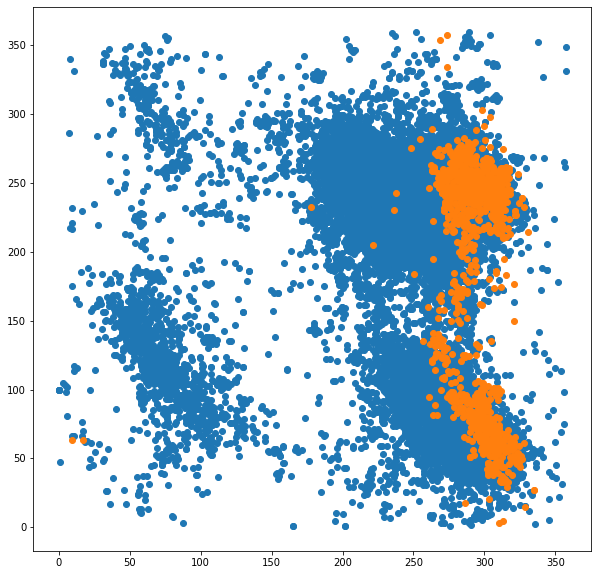

In [27]:
compareCluster('PRO')

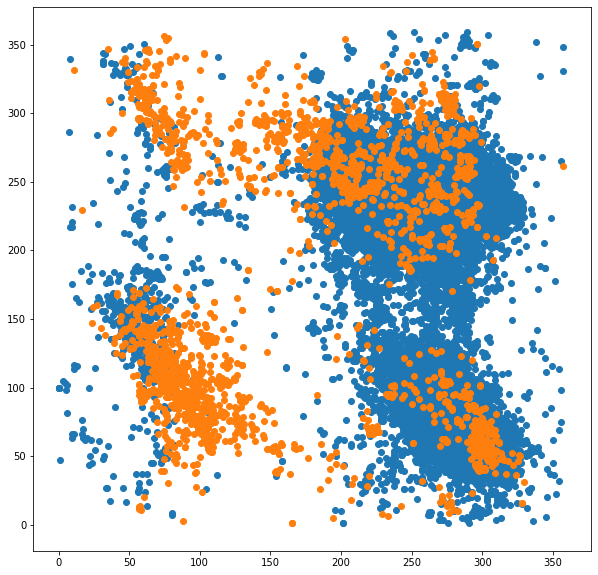

In [28]:
compareCluster('GLY')